# Тихо, алгоритъмът сънува...

### Поглед към Deep dreaming алгоритмите


## Резюме

<b> Дълбокото сънуване, или Deep Dreaming, </b> е сред първите направления в невронните мрежи, които показват, че те могат по своеобразен начин да създават изкуство. 

Разработката (по традиция) е свързана с [журналистически материал, който предстои да бъде публикуван](https://docs.google.com/document/d/1ohBgEeifDdDey0bq3Qo3kRcYxLBrFIlSBRXdRRlZTHQ/edit?usp=sharing) на сайта „Дигитални истории“ и в който се разказва за направлението, историята му и прелюбопитните му приложения. 


In [1]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Имплементация

Основният използван източник е имплементацията на Deep Dreaming алгоритъм в примерните приложения на TensorFlow.

[Оригиналната имплементация](https://github.com/google/deepdream) на Мордвинцев и колегите му днес е на практика неизползваема (както става ясно и от [материала](https://docs.google.com/document/d/1ohBgEeifDdDey0bq3Qo3kRcYxLBrFIlSBRXdRRlZTHQ/edit?usp=sharing) в „Дигитални истории“), защото използва много външни библиотеки, които вече не се поддържат.

## Изображение
Зареждане и предварителна обработка на изображението

In [2]:
url = 'https://m.netinfo.bg/media/images/47299/47299454/896-504-f.jpg'

In [3]:
def show_image(img):
    img = (img * 255).astype(np.uint8)
    return PIL.Image.fromarray(img)

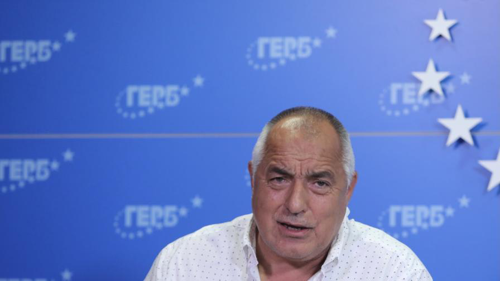

In [4]:
# Сваляне и запазване като NumPy масив
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Нормализация
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Показване
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Смаляване за по-лесна обработка
original_img = download(url, max_dim=500)
show(original_img)

## Подготвяне на модел

Сваляне и подготовка на предварително трениран модел за класифициране на изображения. Използван е [InceptionV3](https://keras.io/api/applications/inceptionv3/) от Keras, който се смята за максимално подобен на този, избран от Мордвинцев и колегите му за първоначалната имплементация на Deep Dream. За определянето на теглата се използва класическият набор от данни Imagenet, също в унисон с оригиналната имплементация.

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

При „дълбокото сънуване“ се избират един или няколко слоеве от невронната мрежа, като същевременно се увеличават резултатите от функцията на загубата, като по този начин се открояват максимално явленията, които са „ентусиазирали“ съответните слоеве. Началните слоеве показват по-елементарни структури, крайните улавят фини детайли.


In [6]:
# Увеличаване на активациите за съответните слоеве
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Създаване на модела
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [7]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

След като е изчислена функцията на загубата, следва изчисляване и нормализиране на градиентите.

In [8]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          tape.watch(img)
          loss = calc_loss(img, self.model)

        gradients = tape.gradient(loss, img)

        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [9]:
deepdream = DeepDream(dream_model)

## Основна опростена функция

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

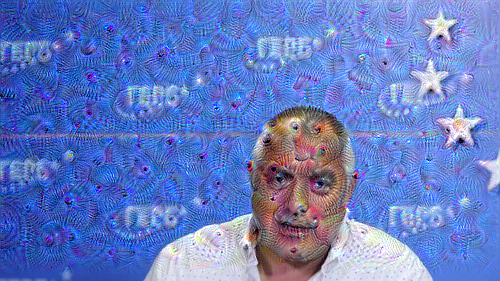

In [11]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

Ето как изглеждат и само добавените от невронната мрежа детайли.

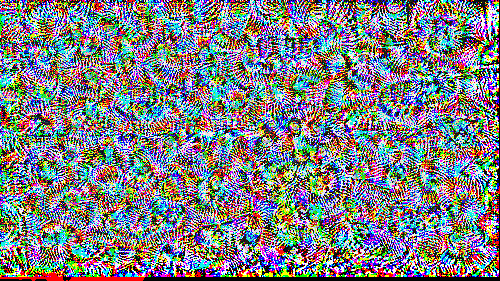

In [13]:
show(dream_img - original_img)

## Допълнително развитие

„Дълбокото сънуване“ е факт, изображението е създадено и доста интересно, но има шум, с ниска резолюция е и, което е по-важно: шаблоните, които са се появили, са еднообразни и си личат закономерностите. 

Затова следващата стъпка е изображението да се раздели на части, да се потърсят същите закономерности в детайлите му и после да се насложат в общата картина.


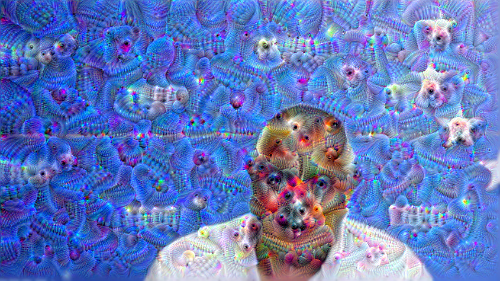

In [14]:
OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

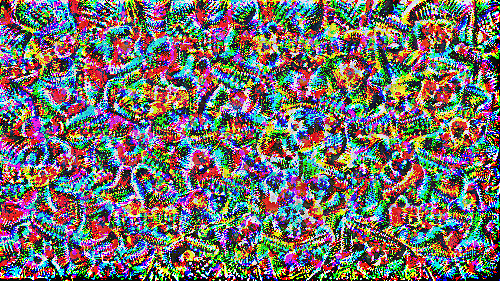

In [15]:
show(original_img - img)

## Нататък

Още една имплементация позволява работата с по-големи изображения или пък такива, които са разделени на повече части. При този подход изчисленията се правят поотделно.

In [16]:
def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

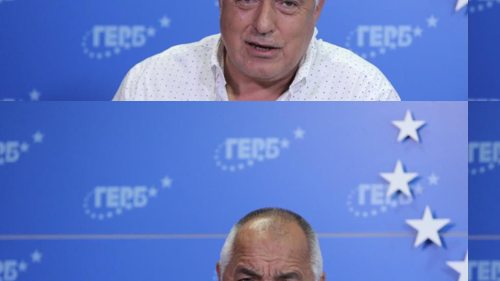

In [17]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [18]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    gradients = tf.zeros_like(img_rolled)
    
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        with tf.GradientTape() as tape:
          tape.watch(img_rolled)

          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        gradients = gradients + tape.gradient(loss, img_rolled)

    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [19]:
get_tiled_gradients = TiledGradients(dream_model)

In [20]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

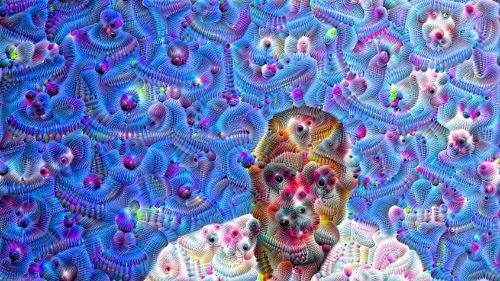

In [21]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

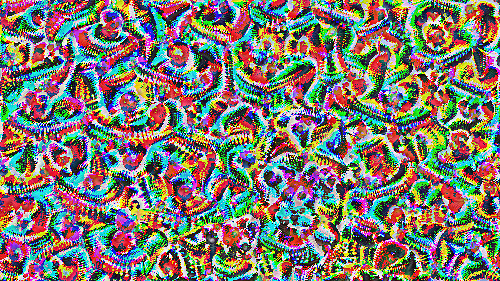

In [22]:
show(original_img - img)

## Експерименти

Всяка промяна в октавите, скалите и активираните слоеве променя драстично изображението. Тъй като отнема доста изчислително време, ще го покажем само със слоевете и малка промяна в скалата на октавите.

Interseption-v3 има 48 слоя дълбочина. Избираме такива от началните, средните и крайните.


In [23]:
print([layer.name for layer in base_model.layers])

['input_1', 'conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'max_pooling2d_1', 'conv2d_8', 'batch_normalization_8', 'activation_8', 'conv2d_6', 'conv2d_9', 'batch_normalization_6', 'batch_normalization_9', 'activation_6', 'activation_9', 'average_pooling2d', 'conv2d_5', 'conv2d_7', 'conv2d_10', 'conv2d_11', 'batch_normalization_5', 'batch_normalization_7', 'batch_normalization_10', 'batch_normalization_11', 'activation_5', 'activation_7', 'activation_10', 'activation_11', 'mixed0', 'conv2d_15', 'batch_normalization_15', 'activation_15', 'conv2d_13', 'conv2d_16', 'batch_normalization_13', 'batch_normalization_16', 'activation_13', 'activation_16', 'average_pooling2d_1', 'conv2d_12', 'conv2d_14', 'conv2d_17', 'conv2d_18', 'batch_normalization_12', 'batch_normaliza

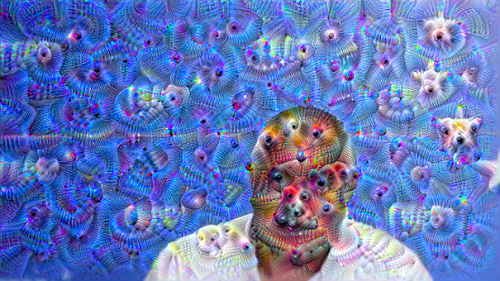

In [24]:
OCTAVE_SCALE = 1.10

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

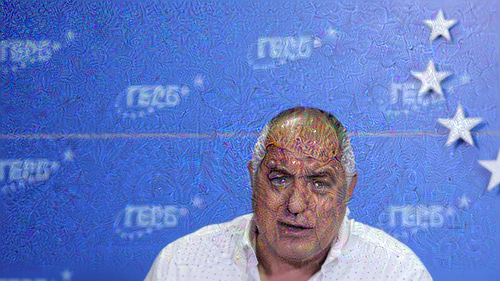

In [25]:
names = ['mixed6', 'mixed8']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

deepdream = DeepDream(dream_model)

dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

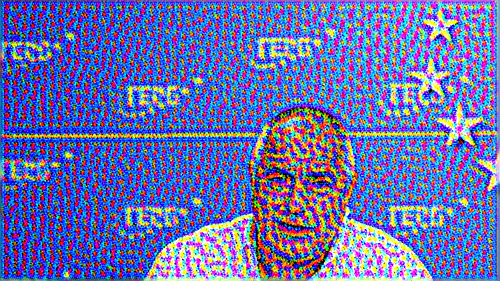

In [26]:
names = ['activation_1', 'activation_2']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

deepdream = DeepDream(dream_model)

dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

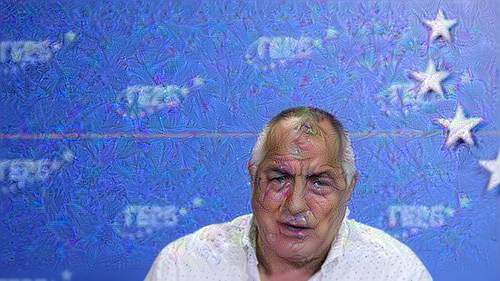

In [27]:
names = ['activation_41', 'activation_46']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

deepdream = DeepDream(dream_model)

dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

## Случаен шум

А дали алгоритъмът ще „сънува“ закономерности и в случайно генериран шум?

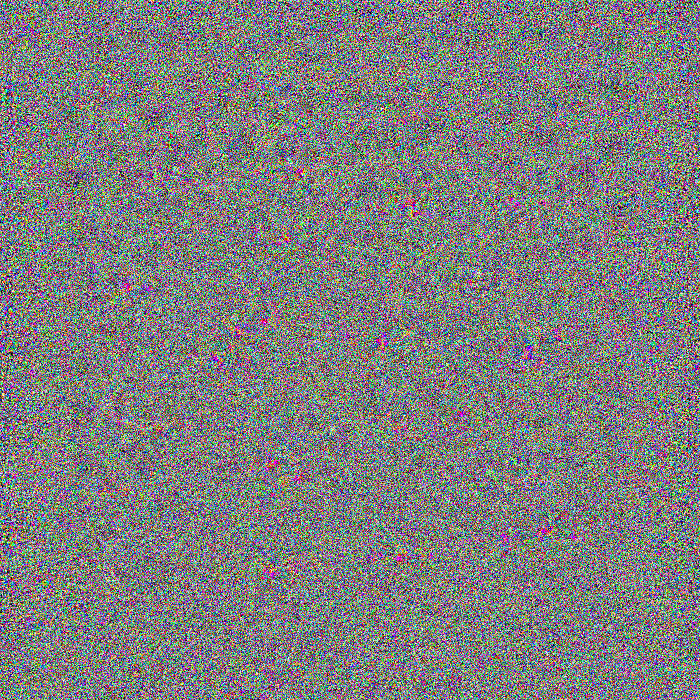

In [28]:
np.random.seed(8)
random = np.random.rand(700, 700, 3)
image_to_process = (random * 255).astype(np.uint8)

a =  run_deep_dream_simple(img=image_to_process, 
                                   steps=100, step_size=0.01)